In [174]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch as th
import torch.nn as nn
from torch import Tensor

In [2]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/audiogoal_rgb_nocont.yaml"),

    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "deep-etho",
                    "perceiver-gwt-gwwm", "perceiver-gwt-attgru"]),
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)


In [3]:

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
single_observation_space = envs.observation_spaces[0]
single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

2022-10-12 11:48:58,874 Initializing dataset AudioNav
2022-10-12 11:48:58,883 Initializing dataset AudioNav
2022-10-12 11:50:04,897 initializing sim SoundSpacesSim
2022-10-12 11:50:05,197 Initializing task AudioNav


(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 ActionSpace(MOVE_FORWARD:EmptySpace(), STOP:EmptySpace(), TURN_LEFT:EmptySpace(), TURN_RIGHT:EmptySpace()))

In [4]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
from models import ActorCritic, Perceiver_GWT_GWWM_ActorCritic
## PPO GRU agent working with RGB observations
# ppo_gru_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro_seed_111__2022_09_06_13_59_13_931240.musashi/models/ppo_agent.994501.ckpt.pth")
# ppo_gru_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab-bc/ppo_bc2__ss1_rgb_spectro__gru__bsize_32_bchnklen_32__nsteps_50__entcoef_0.0__cew_58_1_1_1_seed_111__2022_10_06_10_28_22_571481.musashi/models/ppo_agent.3990001.ckpt.pth")
ppo_gru_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab-bc/ppo_bc2__ss1_rgb_spectro__gru__bsize_32_bchnklen_32__nsteps_50__cew_38.6_0.67_0.84_0.78_nogradnorm_seed_111__2022_10_08_17_24_31_002321.musashi/models/ppo_agent.3990001.ckpt.pth")

ppo_gru_agent = ActorCritic(single_observation_space, single_action_space, args.hidden_size, extra_rgb=False,
    analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
ppo_gru_agent.eval()
ppo_gru_agent.load_state_dict(ppo_gru_agent_state_dict)

## PPO PGWT working with RGB observations
# ppo_pgwt_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2022_09_06_14_43_49_094181.musashi/models/ppo_agent.993001.ckpt.pth")
# ppo_pgwt_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab-bc/ppo_bc2__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAprevlats__bsize_32_bchnklen_32__nsteps_50__entcoef_0__cew_58_1_1_1_seed_111__2022_10_06_10_28_22_227218.musashi/models/ppo_agent.3990001.ckpt.pth")
ppo_pgwt_agent_state_dict = th.load("/home/rousslan/random/rl/exp-logs/ss-hab-bc/ppo_bc2__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAprevlats__bsize_32_bchnklen_32__nsteps_50__cew_38.6_0.67_0.84_0.78_nogradnorm_seed_111__2022_10_08_17_24_31_001985.musashi/models/ppo_agent.3990001.ckpt.pth")
ppo_pgwt_agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
    analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
ppo_pgwt_agent.eval()
ppo_pgwt_agent.load_state_dict(ppo_pgwt_agent_state_dict)

<All keys matched successfully>

In [5]:

# Collecting episode data
## Helper
dev = th.device("cpu")
def tensorize_obs_dict(obs, device, observations=None, rollout_step=None):
    obs_th = {}
    for obs_field, _ in obs[0].items():
        v_th = th.Tensor(np.array([step_obs[obs_field] for step_obs in obs], dtype=np.float32)).to(device)
        # in SS1.0, the dcepth observations comes as [B, 128, 128, 1, 1], so fix that
        if obs_field == "depth" and v_th.dim() == 5:
            v_th = v_th.squeeze(-1)
        obs_th[obs_field] = v_th
        # Special case when doing the rollout, also stores the 
        if observations is not None:
            observations[obs_field][rollout_step] = v_th
    
    return obs_th

obs_list, reward_list, done_list, info_list, action_list = [], [], [], [], []
obs_th_list, done_th_list = [], [] 

rnn_hidden_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)

obs, done = envs.reset(), [False for _ in range(args.num_envs)]
done_th = th.Tensor(done).to(dev)
masks = 1. - done_th[:, None]

while not done_th.sum():
    obs_th = tensorize_obs_dict(obs, dev)
    done_th = th.Tensor(done).to(dev)
    with th.no_grad():
        action, action_probs, action_logprobs, _, value, rnn_hidden_state = \
            ppo_gru_agent.act(obs_th, rnn_hidden_state, masks=masks)
    
    outputs = envs.step([a[0].item() for a in action])
    next_obs, reward, next_done, info = [list(x) for x in zip(*outputs)]

    # NOTE obs_list and done_list would have one extra position than info_list
    obs_list.append(obs)
    done_list.append(done)
    obs_th_list.append(obs_th)
    done_th_list.append(done_th)

    reward_list.append(reward)
    info_list.append(info)
    action_list.append(action.cpu().numpy())

    # Prepare for the next step
    obs = next_obs
    done = next_done

    # DEBUG: producing shorter sequence for downstream tests
    # if len(obs_list) >= 100:
    #     break

len(obs_list) # Episode length

20

In [6]:
# Intead of an episode sampled by the agents we have loaded, use manually stored episode data
import pickle as pkl

with open("obs_list__2022_09_21_13_35_dump.pkl", "rb") as f:
    obs_list = pkl.load(f)

obs_list = obs_list[:80] # Manual capping for better visibility

# Match the expected format of the obs_th_list and done_th_list below
# type(done_th_list), len(done_th_list) # (list, 21)
# type(done_th_list[0]), len(done_th_list[0]) # (torch.Tensor, 1)
done_th_list2 = [th.Tensor([0]) for _ in range(len(obs_list))]
# type(done_th_list2), len(done_th_list2) # (list, 80)
# type(done_th_list2[0]), len(done_th_list2[0]) # (torch.Tensor, 1)


# type(obs_th_list), len(obs_th_list)
# type(obs_th_list[0]), len(obs_th_list[0]), list(obs_th_list[0].keys()) # (dict, 3, ['rgb', 'audiogoal', 'spectrogram'])
# [v.shape for v in obs_th_list[0].values()] # [torch.Size([1, 128, 128, 3]), torch.Size([1, 2, 16000]), torch.Size([1, 65, 26, 2])]

obs_th_list2 = [{k: th.Tensor(v)[None, :] for k,v in obs_list[i][0].items()} for i in range(len(obs_list))]
# type(obs_th_list2[0]), len(obs_th_list2[0]), list(obs_th_list2[0].keys()) # (dict, 3, ['rgb', 'audiogoal', 'spectrogram']), matching 'obs_th_list" expecteation
# [v.shape for v in obs_th_list2[0].values()] # [torch.Size([1, 128, 128, 3]), torch.Size([1, 2, 16000]), torch.Size([1, 65, 26, 2])]


In [7]:
# Feed a given trajectory to each agent type, and collect the intermediate features of the network at each step
ppo_gru_analysis_feats__raw = {}
ppo_pgwt_analysis_feats__raw = {}

# Resets the rnn_hidden_states for each agent
gru_rnn_hidden_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
pgwt_rnn_hidden_state = ppo_pgwt_agent.state_encoder.latents.clone()
gru_rnn_hidden_state.shape, pgwt_rnn_hidden_state.shape

# for t, (obs_th, done_th) in enumerate(zip(obs_th_list, done_th_list)):
for t, (obs_th, done_th) in enumerate(zip(obs_th_list2, done_th_list2)):
    # Feeding the same sequence of observatiosn to each type of agent
    masks = 1. - done_th[:, None]
    with th.no_grad():
        # NOTE: rnn_hidden_state or pgwt's latent are already collected in "state_encoder" field in _features
        _, _, _, _, _, rnn_hidden_state = ppo_gru_agent.act(obs_th, rnn_hidden_state, masks)
        _, _, _, _, _, pgwt_rnn_hidden_state = ppo_pgwt_agent.act(obs_th, pgwt_rnn_hidden_state, masks)


    # Collecting intermediate layer results
    ## PPO GRU
    for k,v in ppo_gru_agent._features.items():
        if k not in list(ppo_gru_analysis_feats__raw.keys()):
            ppo_gru_analysis_feats__raw[k] = []
        ppo_gru_analysis_feats__raw[k].append(v)
    
    ## PPO PGWT
    for k, v in ppo_pgwt_agent._features.items():
        if k not in list(ppo_pgwt_analysis_feats__raw.keys()):
            ppo_pgwt_analysis_feats__raw[k] = []
        ppo_pgwt_analysis_feats__raw[k].append(v)

# TODO: additioanl processing to make it nicely organized tensors
## NOTE: there are some keys that will have tuple of shape 2 or 3, need to take account for that
ppo_gru_analysis_feats = {}
ppo_pgwt_analysis_feats = {}

def process_analysis_feats_raw(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.cat(v, dim=0)
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.cat(vv, dim=0) for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

ppo_gru_analysis_feats = process_analysis_feats_raw(ppo_gru_analysis_feats__raw)
ppo_pgwt_analysis_feats = process_analysis_feats_raw(ppo_pgwt_analysis_feats__raw)

In [8]:
list(ppo_gru_analysis_feats.keys())

ppo_gru_analysis_feats["state_encoder"][0].shape, ppo_gru_analysis_feats["state_encoder"][1].shape
ppo_pgwt_analysis_feats["state_encoder"][0].shape, ppo_pgwt_analysis_feats["state_encoder"][1].shape

ppo_gru_analysis_feats["state_encoder"][0].shape, ppo_pgwt_analysis_feats["state_encoder"][0].shape

ppo_gru_analysis_feats["visual_encoder.cnn.0"][0].shape, ppo_pgwt_analysis_feats["visual_encoder.cnn.0"][0].shape
ppo_gru_analysis_feats["visual_encoder.cnn.1"][0].shape, ppo_pgwt_analysis_feats["visual_encoder.cnn.1"][0].shape
ppo_gru_analysis_feats["visual_encoder.cnn.1"][-100:].shape, ppo_pgwt_analysis_feats["visual_encoder.cnn.1"][-100:].shape
# list(ppo_gru_analysis_feats__raw.keys())

## Attention weights
ppo_pgwt_analysis_feats["state_encoder.ca.mha"][0].shape, ppo_pgwt_analysis_feats["state_encoder.ca.mha"][1].shape

# len(ppo_gru_analysis_feats__raw["state_encoder"]), len(ppo_gru_analysis_feats__raw["state_encoder"][0])
# ppo_gru_analysis_feats["critic.fc"].shape
# th.cat(ppo_gru_analysis_feats["critic.fc"], dim=0).shape # [T, ...]

# ppo_gru_analysis_feats["visual_encoder.cnn.0"].shape
# th.cat(ppo_gru_analysis_feats["visual_encoder.cnn.0"], dim=0).shape # [T, ...]

(torch.Size([80, 8, 64]), torch.Size([80, 8, 3]))

In [9]:
ppo_pgwt_analysis_feats["state_encoder"][0].shape, ppo_pgwt_analysis_feats["state_encoder"][1].shape

(torch.Size([80, 512]), torch.Size([80, 8, 64]))

(<Figure size 576x576 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'PPO PGWT: state_feats'}>]],
       dtype=object),
 defaultdict(dict,
             {<AxesSubplot:title={'center':'PPO PGWT: state_feats'}>: {'image': <matplotlib.image.AxesImage at 0x7f50c71e7dc0>}}))

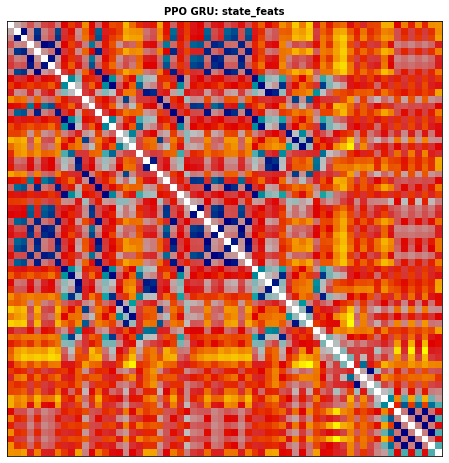

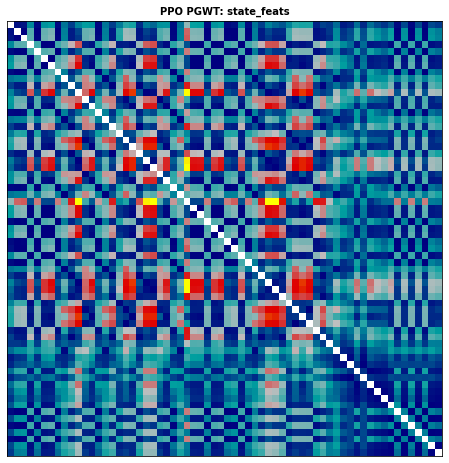

In [10]:
# Basic RSA Toolbox usage
import rsatoolbox

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["visual_encoder.cnn.0"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["visual_encoder.cnn.0"].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["visual_encoder.cnn.7"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["visual_encoder.cnn.7"].flatten(start_dim=1).cpu().numpy())

ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["state_encoder"][0][-64:].flatten(start_dim=1).cpu().numpy())
ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["state_encoder"][0][-64:].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["critic.fc"].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["critic.fc"].flatten(start_dim=1).cpu().numpy())

# ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats["action_distribution.linear"][-64:].flatten(start_dim=1).cpu().numpy())
# ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats["action_distribution.linear"][-64:].flatten(start_dim=1).cpu().numpy())

ppo_gru_rdms = rsatoolbox.rdm.calc_rdm(ppo_gru_data)
ppo_pgwt_rdms = rsatoolbox.rdm.calc_rdm(ppo_pgwt_data)

FIGSIZE = (8,8)
rsatoolbox.vis.show_rdm(ppo_gru_rdms, figsize=FIGSIZE, rdm_descriptor=f"PPO GRU: state_feats")
rsatoolbox.vis.show_rdm(ppo_pgwt_rdms, figsize=FIGSIZE, rdm_descriptor=f"PPO PGWT: state_feats")

In [157]:
# Systematic plotting for each shared intermediate layers
# list(ppo_gru_analysis_feats.keys()), list(ppo_pgwt_analysis_feats.keys())
all_layers = set([
    *list(ppo_gru_analysis_feats.keys()),
    *list(ppo_pgwt_analysis_feats.keys())
])
shared_layers = []
visual_encoder_layernames = []
audio_encoder_layernames = []
for x in all_layers:
    if x in ppo_gru_analysis_feats.keys() and x in ppo_pgwt_analysis_feats.keys():
        shared_layers.append(x)
    if x.startswith("visual_encoder"):
        visual_encoder_layernames.append(x)
    if x.startswith("audio_encoder"):
        audio_encoder_layernames.append(x)

# Place holder for average dissimilarities
rdms_mean_std = {
    "ppo_gru": {},
    "ppo_pgwt": {}
}

# DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_euclid
DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_correlation
layerwise_rdms = {
    "ppo_gru": {},
    "ppo_pgwt": {}
}

for layername in sorted(shared_layers):
    # TODO: handle this special case
    if isinstance(ppo_gru_analysis_feats[layername], list):
        ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats[layername][0][-64:].flatten(start_dim=1).cpu().numpy())
        ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats[layername][0][-64:].flatten(start_dim=1).cpu().numpy())
    else:
        ppo_gru_data = rsatoolbox.data.Dataset(ppo_gru_analysis_feats[layername][-64:].flatten(start_dim=1).cpu().numpy())
        ppo_pgwt_data = rsatoolbox.data.Dataset(ppo_pgwt_analysis_feats[layername][-64:].flatten(start_dim=1).cpu().numpy())

    # TODO: change method of comparison cosine dist, whitened cosine dist., Spearman Rho
    # ppo_gru_rdms = rsatoolbox.rdm.calc_rdm(ppo_gru_data)
    # ppo_pgwt_rdms = rsatoolbox.rdm.calc_rdm(ppo_pgwt_data)

    ppo_gru_rdms = DISS_CALC_FN(ppo_gru_data)
    ppo_pgwt_rdms = DISS_CALC_FN(ppo_pgwt_data)
    
    # Store RDMs for latter plots
    layerwise_rdms["ppo_gru"][layername] = ppo_gru_rdms
    layerwise_rdms["ppo_pgwt"][layername] = ppo_pgwt_rdms

    # Compute the mean and std of the dissimilarities
    rdms_mean_std["ppo_gru"][layername] = {"mean": np.mean(ppo_gru_rdms.dissimilarities), "std": np.std(ppo_gru_rdms.dissimilarities)}
    rdms_mean_std["ppo_pgwt"][layername] = {"mean": np.mean(ppo_pgwt_rdms.dissimilarities), "std": np.std(ppo_pgwt_rdms.dissimilarities)}

    # Plot the RDMS independently
    # rsatoolbox.vis.show_rdm(ppo_gru_rdms, figsize=(8,8), rdm_descriptor=f"PPO GRU: {layername}")
    # rsatoolbox.vis.show_rdm(ppo_pgwt_rdms, figsize=(8,8), rdm_descriptor=f"PPO PGWT: {layername}")

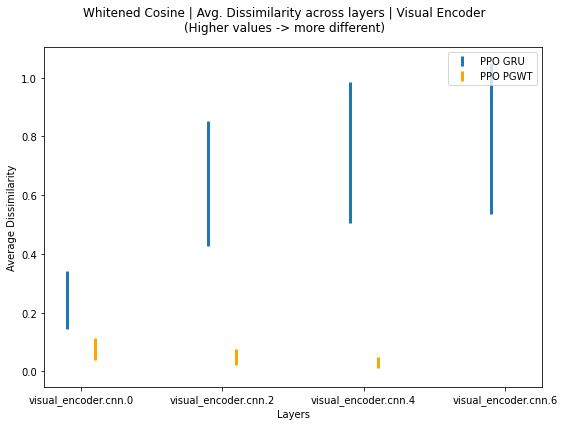

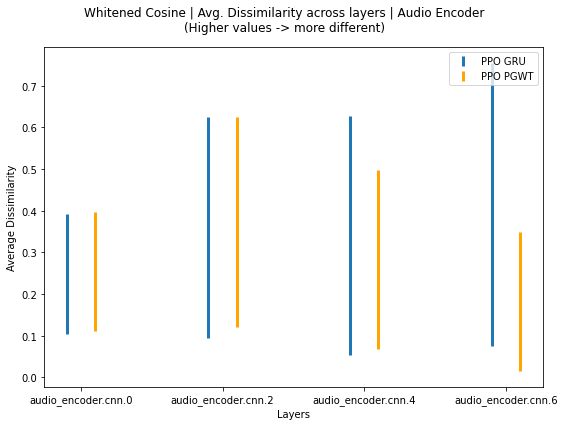

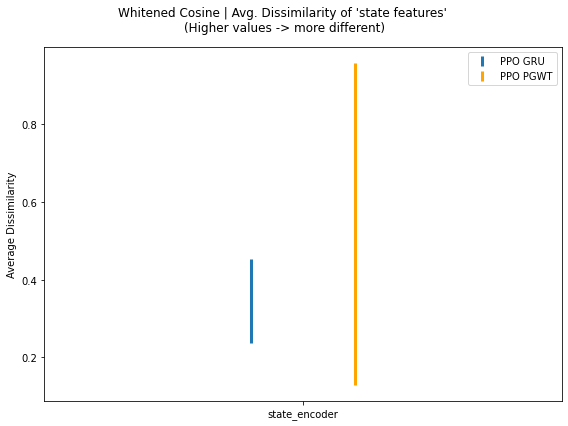

In [141]:
# Average similarity overview plots

# TODO: make it a single plot later, with one subplots for each different componets ?
## Visual encoder section
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer
# x_tickslabels = ["PPO GRU", "PPO PGWT"]

ppo_gru_y = [rdms_mean_std["ppo_gru"][lynm]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
ppo_gru_yerr = [rdms_mean_std["ppo_gru"][lynm]["std"] for lynm in visual_encoder_layernames_relu_skipped]

ppo_pgwt_y = [rdms_mean_std["ppo_pgwt"][lynm]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
ppo_pgwt_yerr = [rdms_mean_std["ppo_pgwt"][lynm]["std"] for lynm in visual_encoder_layernames_relu_skipped]

ax.errorbar(x-0.1, ppo_gru_y, ppo_gru_yerr, fmt="none", elinewidth=3, label="PPO GRU")
ax.errorbar(x+0.1, ppo_pgwt_y, ppo_pgwt_yerr, color="orange", fmt="none", elinewidth=3, label="PPO PGWT")

ax.set_xlabel("Layers")
ax.set_ylabel("Average Dissimilarity")
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(visual_encoder_layernames_relu_skipped)
fig.suptitle("Whitened Cosine | Avg. Dissimilarity across layers | Visual Encoder\n(Higher values -> more different)")
fig.tight_layout()
fig.show()

## Audio encoder section
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer
# x_tickslabels = ["PPO GRU", "PPO PGWT"]

ppo_gru_y = [rdms_mean_std["ppo_gru"][lynm]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
ppo_gru_yerr = [rdms_mean_std["ppo_gru"][lynm]["std"] for lynm in audio_encoder_layernames_relu_skipped]

ppo_pgwt_y = [rdms_mean_std["ppo_pgwt"][lynm]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
ppo_pgwt_yerr = [rdms_mean_std["ppo_pgwt"][lynm]["std"] for lynm in audio_encoder_layernames_relu_skipped]

ax.errorbar(x-0.1, ppo_gru_y, ppo_gru_yerr, fmt="none", elinewidth=3, label="PPO GRU")
ax.errorbar(x+0.1, ppo_pgwt_y, ppo_pgwt_yerr, color="orange", fmt="none", elinewidth=3, label="PPO PGWT")

ax.set_xlabel("Layers")
ax.set_ylabel("Average Dissimilarity")
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(audio_encoder_layernames_relu_skipped)
fig.suptitle("Whitened Cosine | Avg. Dissimilarity across layers | Audio Encoder\n(Higher values -> more different)")
fig.tight_layout()
fig.show()

## State features
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

ppo_gru_y = rdms_mean_std["ppo_gru"]["state_encoder"]["mean"]
ppo_gru_yerr = rdms_mean_std["ppo_gru"]["state_encoder"]["std"]

ppo_pgwt_y = rdms_mean_std["ppo_pgwt"]["state_encoder"]["mean"]
ppo_pgwt_yerr = rdms_mean_std["ppo_pgwt"]["state_encoder"]["std"]

ax.errorbar(1-0.1, ppo_gru_y, ppo_gru_yerr, fmt="none", elinewidth=3, label="PPO GRU")
ax.errorbar(1+0.1, ppo_pgwt_y, ppo_pgwt_yerr, color="orange", fmt="none", elinewidth=3, label="PPO PGWT")

# ax.set_xlabel("Layers")
ax.set_ylabel("Average Dissimilarity")
ax.legend()
ax.set_xticks([1])
ax.set_xticklabels(["state_encoder"])
ax.set_xlim(0.5, 1.5)
fig.suptitle("Whitened Cosine | Avg. Dissimilarity of 'state features' \n(Higher values -> more different)")
fig.tight_layout()
fig.show()

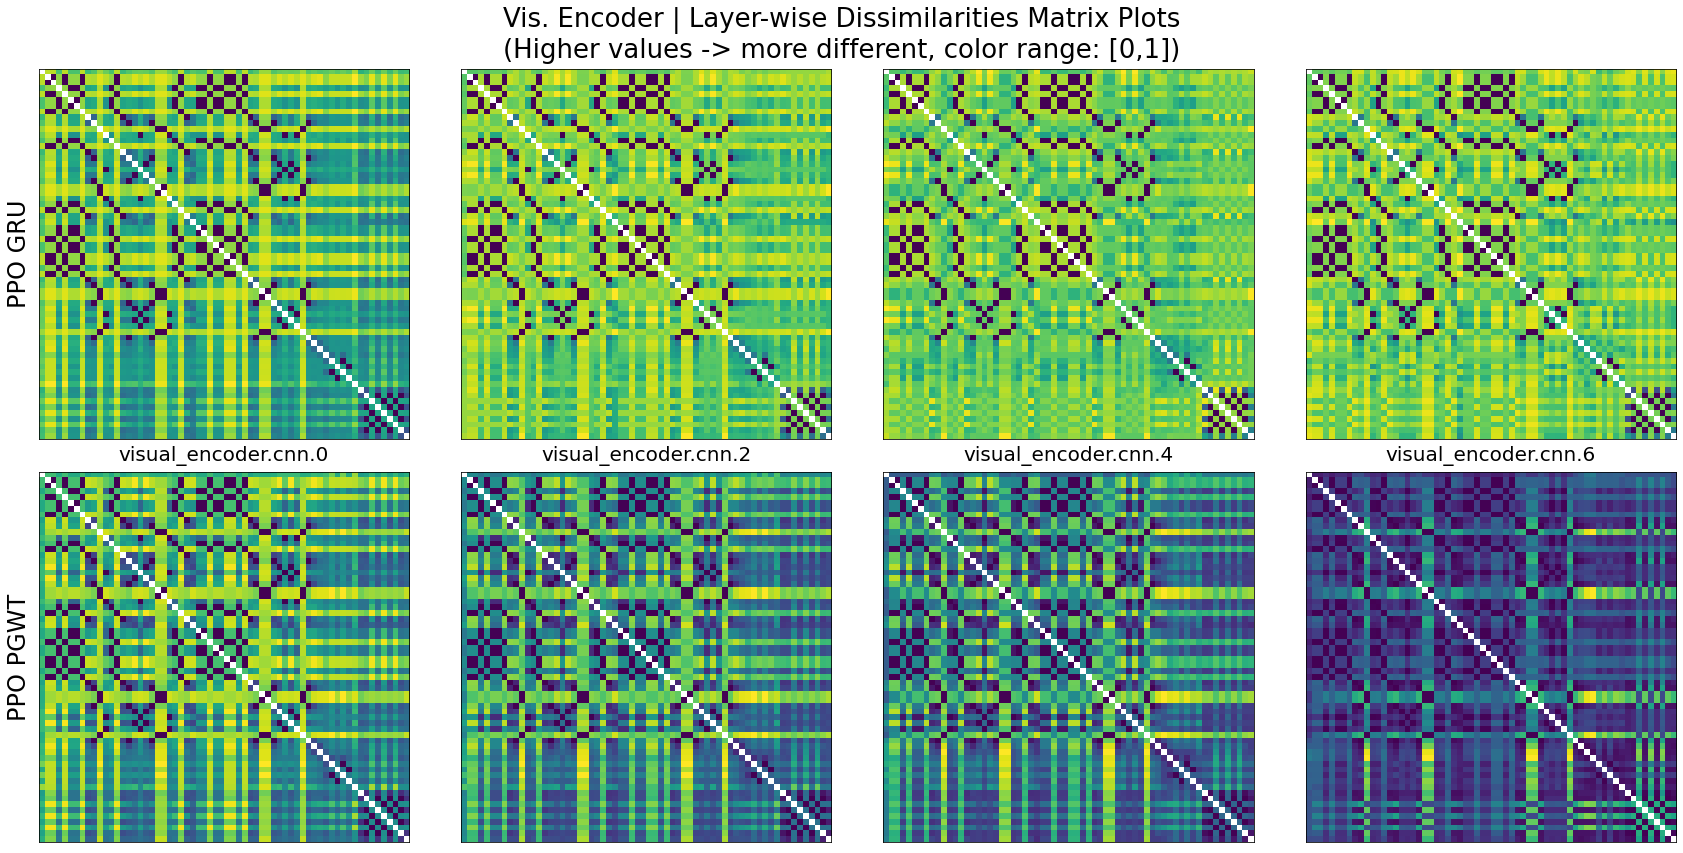

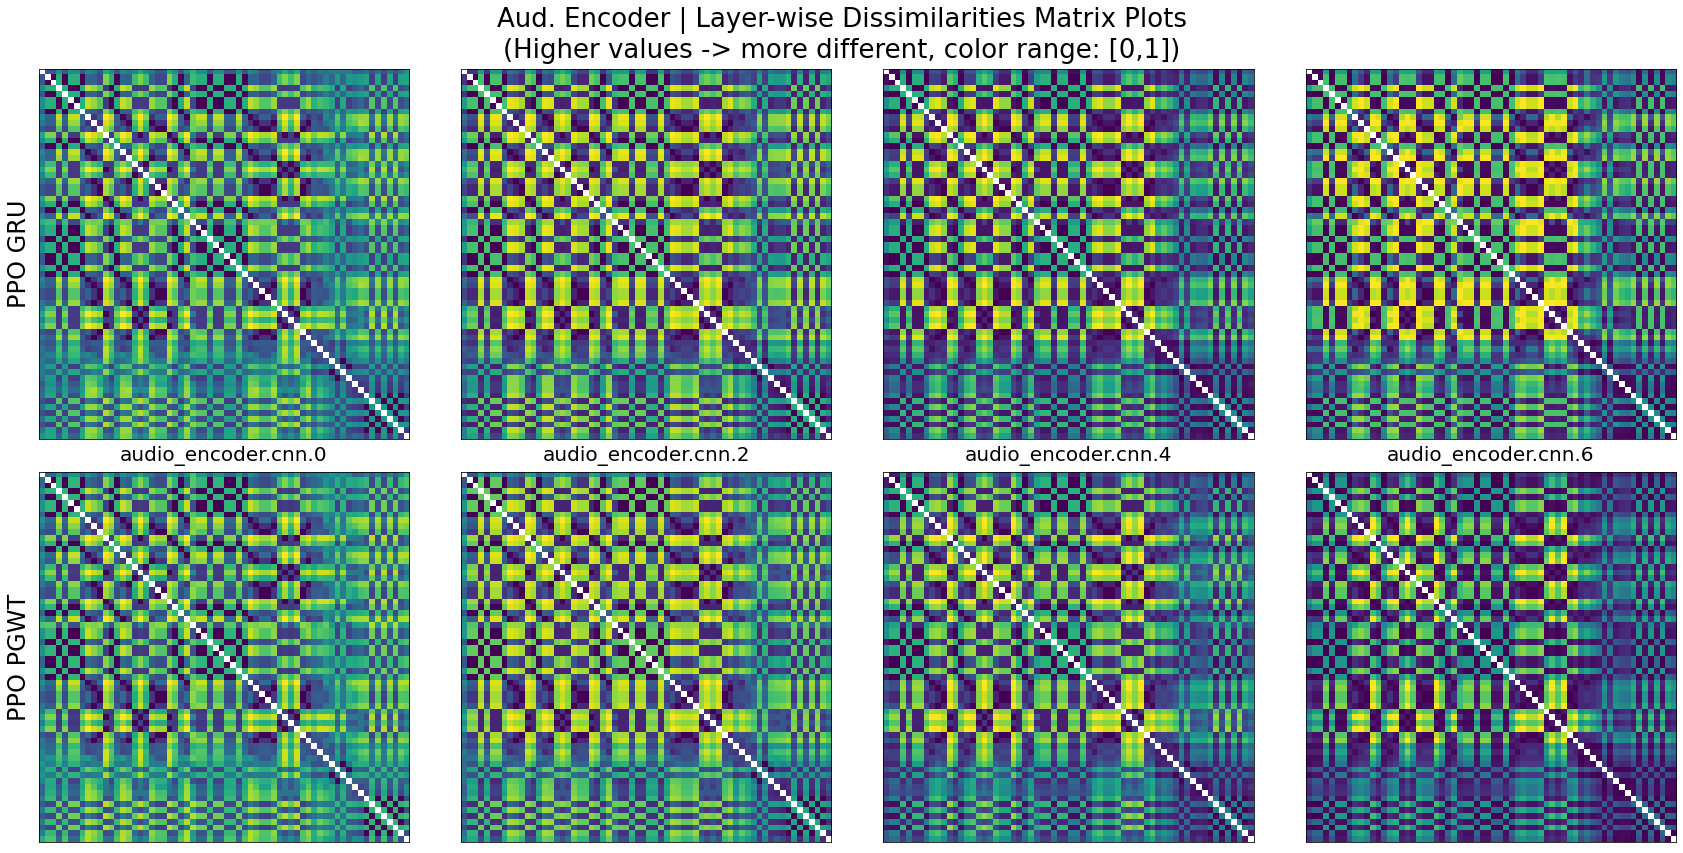

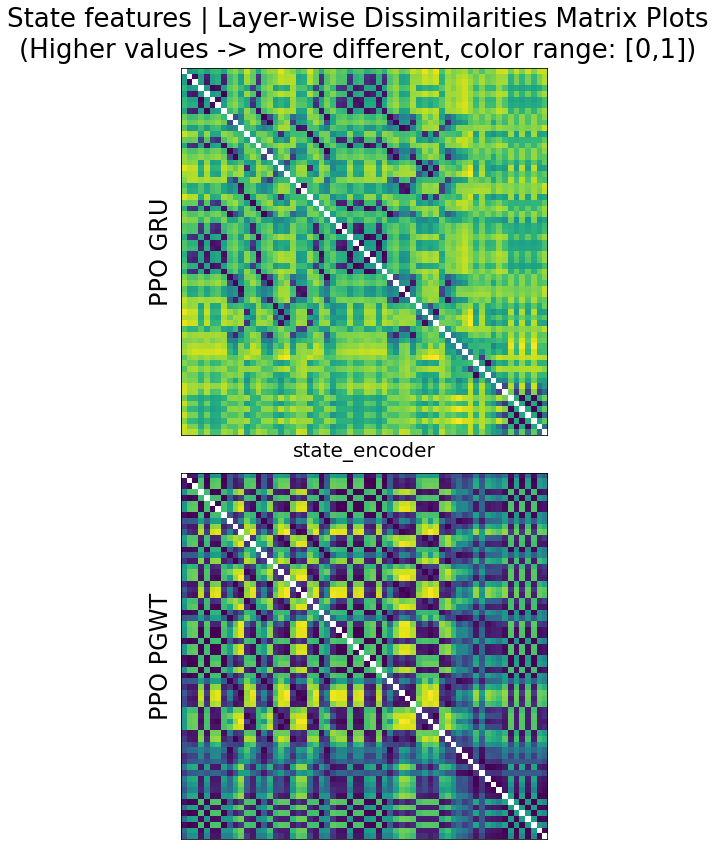

In [209]:
# RSA Dissimilarities plots 
## TODO: add colorbar

## Visual encoder
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

n_rows, n_cols = 2, len(visual_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))

for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_gru"][layername], ax=axes[0][ax_idx], cmap=mpl.colormaps["viridis"])
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_pgwt"][layername], ax=axes[1][ax_idx], cmap=mpl.colormaps["viridis"])
    axes[0][ax_idx].set_xlabel(layername, fontsize=20, position="above")

axes[0][0].set_ylabel("PPO GRU", fontsize=24)
axes[1][0].set_ylabel("PPO PGWT", fontsize=24)

fig.set_facecolor("white")
fig.suptitle("Vis. Encoder | Layer-wise Dissimilarities Matrix Plots\n(Higher values -> more different, color range: [0,1])", fontsize=26)
fig.tight_layout()
fig.show()

## Audio encoder
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

n_rows, n_cols = 2, len(audio_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))

for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_gru"][layername], ax=axes[0][ax_idx], cmap=mpl.colormaps["viridis"])
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_pgwt"][layername], ax=axes[1][ax_idx], cmap=mpl.colormaps["viridis"])
    axes[0][ax_idx].set_xlabel(layername, fontsize=20, position="above")

axes[0][0].set_ylabel("PPO GRU", fontsize=24)
axes[1][0].set_ylabel("PPO PGWT", fontsize=24)

fig.set_facecolor("white")
fig.suptitle("Aud. Encoder | Layer-wise Dissimilarities Matrix Plots\n(Higher values -> more different, color range: [0,1])", fontsize=26)
fig.tight_layout()
fig.show()

## State features
n_rows, n_cols = 2, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))

for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_gru"]["state_encoder"], ax=ax[0], cmap=mpl.colormaps["viridis"])
    rsatoolbox.vis.show_rdm_panel(layerwise_rdms["ppo_pgwt"]["state_encoder"], ax=ax[1], cmap=mpl.colormaps["viridis"])
    ax[0].set_xlabel("state_encoder", fontsize=20, position="above")

ax[0].set_ylabel("PPO GRU", fontsize=24)
ax[1].set_ylabel("PPO PGWT", fontsize=24)

fig.set_facecolor("white")
fig.suptitle("State features | Layer-wise Dissimilarities Matrix Plots\n(Higher values -> more different, color range: [0,1])", fontsize=26)
fig.tight_layout()
fig.show()

In [126]:
# Comparing the two networks against each other
rsatoolbox.rdm.compare(ppo_gru_rdms, ppo_pgwt_rdms, method="cosine"), rsatoolbox.rdm.compare(ppo_gru_rdms, ppo_pgwt_rdms, method="spearman")
# rsatoolbox.rdm.compare_spearman(ppo_gru_rdms, ppo_pgwt_rdms)

(array([[0.82049413]]), array([[0.59422089]]))

In [13]:
# Computing sparsity
## 1 indicates very selective response, while 0 indicates equal response to all inputs
ppo_gru_analysis_feats["visual_encoder.cnn.0"]

# vis_cnn_0__response_list = ppo_gru_analysis_feats["visual_encoder.cnn.0"].flatten(start_dim=1)

# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

# vis_cnn_0__neuron_sparsity = compute_sparsity(vis_cnn_0__response_list); vis_cnn_0__neuron_sparsity.mean()
# [vis_cnn_0__response_list[:, i].sum().pow(2) for i in range(vis_cnn_0__response_list.shape[1])]
# [vis_cnn_0__response_list[:, i].pow(2).sum() for i in range(vis_cnn_0__response_list.shape[1])]

layer_sparsities = {
    "ppo_gru": {},
    "ppo_pgwt": {}
}

for layername in sorted(shared_layers):
    if isinstance(ppo_gru_analysis_feats[layername], list):
        ppo_gru_layer_response_list = ppo_gru_analysis_feats[layername][0].flatten(start_dim=1)
        ppo_pgwt_layer_response_list = ppo_pgwt_analysis_feats[layername][0].flatten(start_dim=1)
    else:
        ppo_gru_layer_response_list = ppo_gru_analysis_feats[layername].flatten(start_dim=1)
        ppo_pgwt_layer_response_list = ppo_pgwt_analysis_feats[layername].flatten(start_dim=1)
    
    ppo_gru_layer_sparsities = compute_sparsity(ppo_gru_layer_response_list)
    ppo_pgwt_layer_sparsities = compute_sparsity(ppo_pgwt_layer_response_list)

    layer_sparsities["ppo_gru"][layername] = ppo_gru_layer_sparsities
    layer_sparsities["ppo_pgwt"][layername] = ppo_pgwt_layer_sparsities

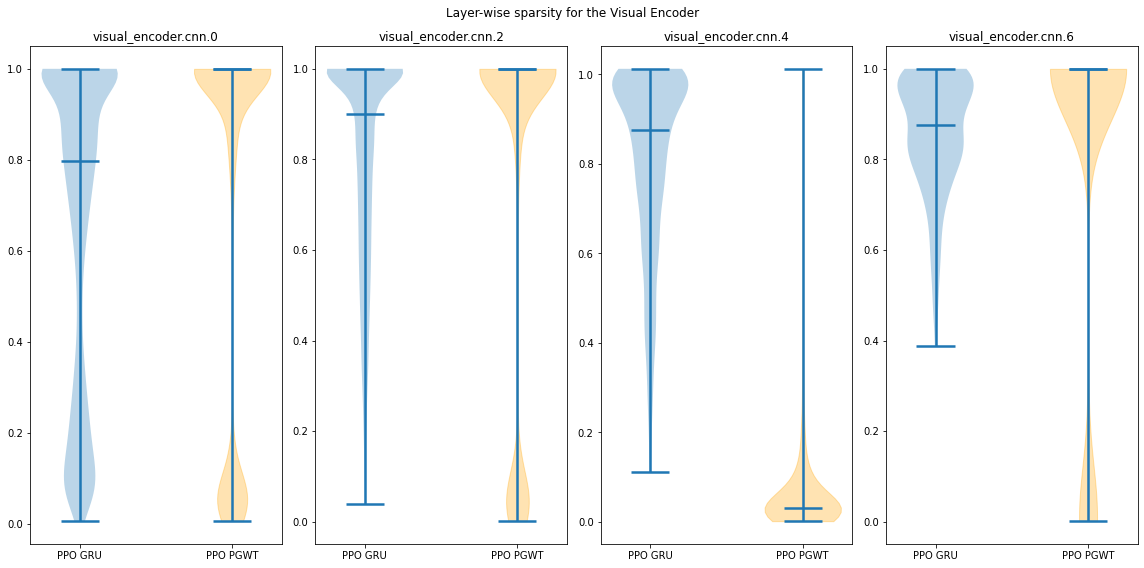

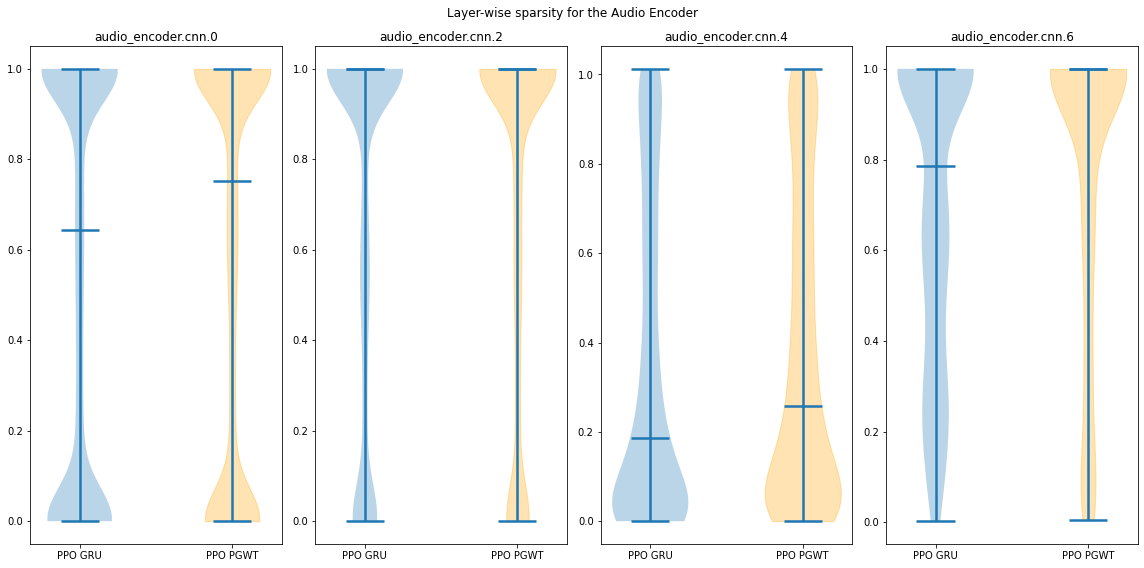

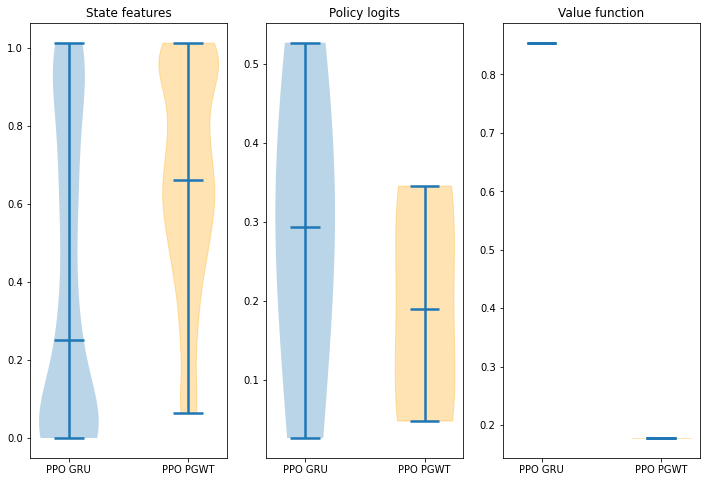

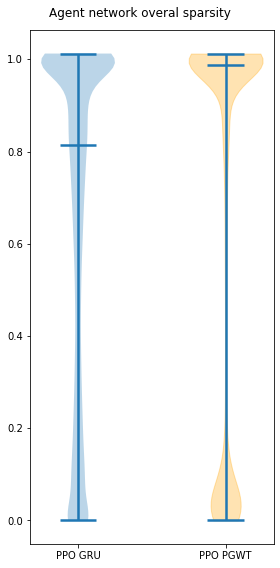

In [75]:
# Sparsity plots components wise
## Note for interpretation: higher sparsity values means that neurons specialize to a certain type of input.
## From the paper, "Higher sparsity values means individual units respnd selectively to a smaller number of images"

# TODO: make it a single plot later, with one subplots for each different componets ?
## Visual encoder section
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

n_rows, n_cols = 1, len(visual_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 4, n_rows * 8))

x = np.arange(2) # 2 PPO varaint per plot for each layer
x_tickslabels = ["PPO GRU", "PPO PGWT"]

for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    violin_parts = axes[ax_idx].violinplot([
        layer_sparsities["ppo_gru"][layername],
        layer_sparsities["ppo_pgwt"][layername],
    ], positions=[0,1], showmedians=True)
    # TODO: darker orange for the PPO PGWT varaint
    violin_parts["bodies"][1].set_facecolor("orange")
    violin_parts["bodies"][1].set_edgecolor("orange")
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        # vp.set_edgecolor("orange")
        vp.set_linewidth(2.5)

    axes[ax_idx].set_xticks(x)
    axes[ax_idx].set_xticklabels(x_tickslabels)
    axes[ax_idx].set_title(layername)

fig.suptitle("Layer-wise sparsity for the Visual Encoder")
fig.tight_layout()
fig.show()

## Audio encoder section
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

n_rows, n_cols = 1, len(audio_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 4, n_rows * 8))

x = np.arange(2) # 2 PPO varaint per plot for each layer
x_tickslabels = ["PPO GRU", "PPO PGWT"]

for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
    violin_parts = axes[ax_idx].violinplot([
        layer_sparsities["ppo_gru"][layername],
        layer_sparsities["ppo_pgwt"][layername],
    ], positions=[0,1], showmedians=True)
    # TODO: darker orange for the PPO PGWT varaint
    violin_parts["bodies"][1].set_facecolor("orange")
    violin_parts["bodies"][1].set_edgecolor("orange")
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        # vp.set_edgecolor("orange")
        vp.set_linewidth(2.5)

    axes[ax_idx].set_xticks(x)
    axes[ax_idx].set_xticklabels(x_tickslabels)
    axes[ax_idx].set_title(layername)

fig.suptitle("Layer-wise sparsity for the Audio Encoder")
fig.tight_layout()
fig.show()

## State features / policy / value networks sections
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 4, n_rows * 8))
### state features
violin_parts = axes[0].violinplot([
    layer_sparsities["ppo_gru"]["state_encoder"],
    layer_sparsities["ppo_pgwt"]["state_encoder"]
], positions=[0,1], showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
violin_parts["bodies"][1].set_facecolor("orange")
violin_parts["bodies"][1].set_edgecolor("orange")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_tickslabels)
axes[0].set_title("State features")

### action network
violin_parts = axes[1].violinplot([
    layer_sparsities["ppo_gru"]["action_distribution.linear"],
    layer_sparsities["ppo_pgwt"]["action_distribution.linear"]
], positions=[0,1], showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
violin_parts["bodies"][1].set_facecolor("orange")
violin_parts["bodies"][1].set_edgecolor("orange")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_tickslabels)
axes[1].set_title("Policy logits")

### Critic network (NOTE: pointless for the BC, as the value network is not used)
violin_parts = axes[2].violinplot([
    layer_sparsities["ppo_gru"]["critic.fc"],
    layer_sparsities["ppo_pgwt"]["critic.fc"]
], positions=[0,1], showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
violin_parts["bodies"][1].set_facecolor("orange")
violin_parts["bodies"][1].set_edgecolor("orange")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
axes[2].set_xticks(x)
axes[2].set_xticklabels(x_tickslabels)
axes[2].set_title("Value function")

# region: For the whole network + violin
ppo_gru_sparsities, ppo_pgwt_sparsities = [], []
for layername in shared_layers:
    ppo_gru_sparsities.extend(layer_sparsities["ppo_gru"][layername])
    ppo_pgwt_sparsities.extend(layer_sparsities["ppo_pgwt"][layername])
# len(ppo_gru_sparsities), len(ppo_pgwt_sparsities)

fig, ax = plt.subplots(1,1, figsize=(4,8))
x = np.arange(2)
x_tickslabels = ["PPO GRU", "PPO PGWT"]

violin_parts = ax.violinplot([
    ppo_gru_sparsities, ppo_pgwt_sparsities
], positions=[0, 1], showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
violin_parts["bodies"][1].set_facecolor("orange")
violin_parts["bodies"][1].set_edgecolor("orange")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
ax.set_xticks(x)
ax.set_xticklabels(x_tickslabels)
fig.suptitle("Agent network overal sparsity")
fig.tight_layout()
fig.show()
# endregion: For the whole network + violin

In [66]:
list(layer_sparsities["ppo_gru"].keys())

['action_distribution.linear',
 'audio_encoder.cnn.0',
 'audio_encoder.cnn.1',
 'audio_encoder.cnn.2',
 'audio_encoder.cnn.3',
 'audio_encoder.cnn.4',
 'audio_encoder.cnn.5',
 'audio_encoder.cnn.6',
 'audio_encoder.cnn.7',
 'critic.fc',
 'state_encoder',
 'visual_encoder.cnn.0',
 'visual_encoder.cnn.1',
 'visual_encoder.cnn.2',
 'visual_encoder.cnn.3',
 'visual_encoder.cnn.4',
 'visual_encoder.cnn.5',
 'visual_encoder.cnn.6',
 'visual_encoder.cnn.7']

In [64]:
# TODO: Comparing RDMs

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
squared euclidean
dissimilarities = 
[[18.515062  18.515062  12.6179285 ...  9.241364  10.217552   4.2365685]]
descriptors = 
{}
rdm_descriptors = 
{'index': [0]}
pattern_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], 'pattern': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])}

<ErrorbarContainer object of 3 artists>

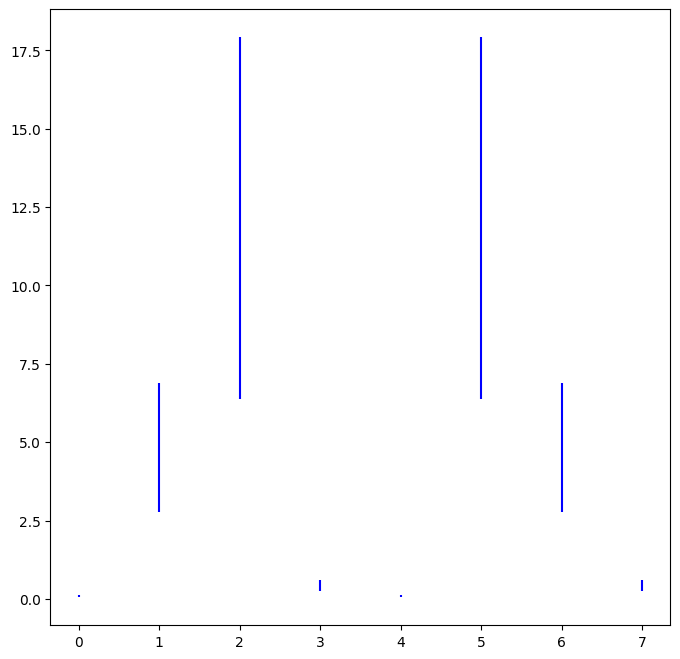

In [57]:
# # Plotting average similiarities
# visual_encoder_layernames, audio_encoder_layernames

import matplotlib.pyplot as plt # TODO: move to the top
fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.arange(len(visual_encoder_layernames))
y = np.array([rdms_mean_std["ppo_gru"][x]["mean"] for x in visual_encoder_layernames])
yerr = np.array([rdms_mean_std["ppo_gru"][x]["std"] for x in visual_encoder_layernames])

ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor='blue', color='black')
# yerr

# x = np.arange(8)
# y1 = np.exp(-1.0 * x)
# yerr = np.random.uniform(0.5,1)

# # ax.errorbar(x, y1)


In [107]:
## Checking the CA's attentin weighting over each modality ?

ppo_pgwt_analysis_feats["state_encoder.ca.mha"][1].shape # Full attention weights over the whole episode [44,8,3]
# ppo_pgwt_analysis_feats["state_encoder.ca.mha"][1][0, :, :].sum(dim=1)

torch.Size([80, 8, 3])

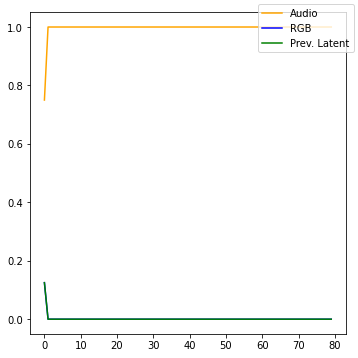

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
ep_length = ppo_pgwt_analysis_feats["state_encoder.ca.mha"][1].shape[0]
x = np.arange(ep_length)

MOD_AXIS_TO_NAME = {0: "Audio", 1: "RGB", 2: "Prev. Latent" }
MOD_AXIS_TO_COLOR = { 0: "orange", 1: "blue", 2: "green" }

for mod_axis in range(3):
    ax.plot(x, ppo_pgwt_analysis_feats["state_encoder.ca.mha"][1].mean(1)[:, mod_axis],
            label=MOD_AXIS_TO_NAME[mod_axis],
            color=MOD_AXIS_TO_COLOR[mod_axis])
fig.legend()
fig.tight_layout()
fig.show()


KeyError: 'name'

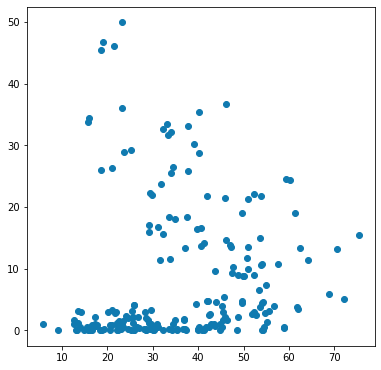

In [14]:
# Comparing RDMs against each other
ppo_gru_rdms = rsatoolbox.rdm.calc_rdm(ppo_gru_data)
ppo_pgwt_rdms = rsatoolbox.rdm.calc_rdm(ppo_pgwt_data)

rsatoolbox.vis.rdm_comparison_scatterplot((ppo_gru_rdms, ppo_pgwt_rdms))

In [ ]:
# Generating video with audio from the sampled episode
import os
import pickle as pkl
from ss_baselines.common.utils import images_to_video_with_audio, plot_top_down_map

video_data = {
    "rgb": [obs[0]["rgb"] for obs in obs_list],
    "audiogoal": [obs[0]["audiogoal"] for obs in obs_list]
}
video_dir_path = "/tmp"
video_filename = "episode_video"

# Save video to file
images_to_video_with_audio(
    images=video_data["rgb"][-64:],
    audios=video_data["audiogoal"][-64:],
    output_dir=video_dir_path,
    video_name=video_filename,
    sr=env_config.TASK_CONFIG.SIMULATOR.AUDIO.RIR_SAMPLING_RATE, # 16000 for mp3d dataset
    fps=1 # Default seems to be 10 though
)

# TODO: check the Notebook video playing feature again
from IPython.display import Video
Video(url=os.path.join(video_dir_path, video_filename))

# Dump the frame dicts for later
filename = "obs_list__2022_09_21_13_35_dump.pkl"
with open(filename, "wb") as f:
    pkl.dump(obs_list, f)